### GPT Paragraph Embedding for Community Detection
This notebook applies paragraph embeddings from GPT (aggregated) and GPT+Bi-LSTM for community detection. It has been noted that GPT is capable of separating sub-topics into different communities at the paragraph level. Aggregated sentence features performs better with the pruning algorithm than the Bi-LSTM based features.

In [534]:
%matplotlib inline
from nltk.cluster.kmeans import KMeansClusterer
import nltk
import argparse
import os
import sys
import csv
import random
import logging
import pickle
import re
from tqdm import tqdm, trange, tqdm_notebook
from math import ceil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from itertools import combinations, product
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from pytorch_pretrained_bert import (OpenAIGPTDoubleHeadsModel, OpenAIGPTTokenizer,
                                     OpenAIAdam, cached_path, WEIGHTS_NAME, CONFIG_NAME)
from pytorch_pretrained_bert.modeling_openai import OpenAIGPTPreTrainedModel,OpenAIGPTDoubleHeadsModel,OpenAIGPTConfig,OpenAIGPTModel,OpenAIGPTLMHead

from scipy.spatial.distance import cosine, cityblock
import iso8601
from datetime import datetime
import json
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)
device = "cpu"



In [535]:
class OpenAIGPTLMHead_custom(nn.Module):
    """ Language Model Head for the transformer """

    def __init__(self, model_embeddings_weights, config):
        super(OpenAIGPTLMHead_custom, self).__init__()
        self.n_embd = config.n_embd
        self.vocab_size = config.vocab_size
        self.predict_special_tokens = config.predict_special_tokens
        embed_shape = model_embeddings_weights.shape
        #print("shape check",(model_embeddings_weights[1]))
        self.decoder = nn.Linear(embed_shape[1], embed_shape[0], bias=False)
        self.set_embeddings_weights(model_embeddings_weights)

    def set_embeddings_weights(self, model_embeddings_weights, predict_special_tokens=True):
        self.predict_special_tokens = predict_special_tokens
        embed_shape = model_embeddings_weights.shape
        self.decoder.weight = model_embeddings_weights  # Tied weights

    def forward(self, hidden_state):
        lm_logits = self.decoder(hidden_state)
        if not self.predict_special_tokens:
            lm_logits = lm_logits[..., :self.vocab_size]
        return lm_logits

class OpenAIGPTMultipleChoiceHead_custom(nn.Module):
    """ Classifier Head for the transformer """

    def __init__(self, config):
        super(OpenAIGPTMultipleChoiceHead_custom, self).__init__()
        self.n_embd = config.n_embd
        self.dropout = nn.Dropout2d(config.resid_pdrop)  # To reproduce the noise_shape parameter of TF implementation
        self.linear = nn.Linear(config.n_embd, 1)

        nn.init.normal_(self.linear.weight, std=0.02)
        nn.init.normal_(self.linear.bias, 0)

    def forward(self, hidden_states, mc_token_ids):
        # Classification logits
        # hidden_state (bsz, num_choices, seq_length, hidden_size)
        # mc_token_ids (bsz, num_choices)
        mc_token_ids = mc_token_ids.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, -1, hidden_states.size(-1))
        multiple_choice_h = hidden_states.gather(2, mc_token_ids).squeeze(2)
        return multiple_choice_h

class OpenAIGPTDoubleHeadsModel_custom(OpenAIGPTPreTrainedModel):
    """
    OpenAI GPT model with a Language Modeling and a Multiple Choice head ("Improving Language Understanding by Generative Pre-Training").
    OpenAI GPT use a single embedding matrix to store the word and special embeddings.
    Special tokens embeddings are additional tokens that are not pre-trained: [SEP], [CLS]...
    Special tokens need to be trained during the fine-tuning if you use them.
    The number of special embeddings can be controled using the `set_num_special_tokens(num_special_tokens)` function.
    The embeddings are ordered as follow in the token embeddings matrice:
        [0,                                                         ----------------------
         ...                                                        -> word embeddings
         config.vocab_size - 1,                                     ______________________
         config.vocab_size,
         ...                                                        -> special embeddings
         config.vocab_size + config.n_special - 1]                  ______________________
    where total_tokens_embeddings can be obtained as config.total_tokens_embeddings and is:
        total_tokens_embeddings = config.vocab_size + config.n_special
    You should use the associate indices to index the embeddings.
    Params:
        `config`: a OpenAIGPTConfig class instance with the configuration to build a new model
        `output_attentions`: If True, also output attentions weights computed by the model at each layer. Default: False
        `keep_multihead_output`: If True, saves output of the multi-head attention module with its gradient.
            This can be used to compute head importance metrics. Default: False
    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, num_choices, sequence_length] with the BPE token
            indices selected in the range [0, total_tokens_embeddings[
        `mc_token_ids`: a torch.LongTensor of shape [batch_size, num_choices] with the index of the token from
            which we should take the hidden state to feed the multiple choice classifier (usually last token of the sequence)
        `position_ids`: an optional torch.LongTensor with the same shape as input_ids
            with the position indices (selected in the range [0, config.n_positions - 1[.
        `token_type_ids`: an optional torch.LongTensor with the same shape as input_ids
            You can use it to add a third type of embedding to each input token in the sequence
            (the previous two being the word and position embeddings).
            The input, position and token_type embeddings are summed inside the Transformer before the first
            self-attention block.
        `lm_labels`: optional language modeling labels: torch.LongTensor of shape [batch_size, num_choices, sequence_length]
            with indices selected in [-1, 0, ..., total_tokens_embeddings]. All labels set to -1 are ignored (masked), the loss
            is only computed for the labels set in [0, ..., total_tokens_embeddings]
        `multiple_choice_labels`: optional multiple choice labels: torch.LongTensor of shape [batch_size]
            with indices selected in [0, ..., num_choices].
        `head_mask`: an optional torch.Tensor of shape [num_heads] or [num_layers, num_heads] with indices between 0 and 1.
            It's a mask to be used to nullify some heads of the transformer. 1.0 => head is fully masked, 0.0 => head is not masked.
    Outputs:
        if `lm_labels` and `multiple_choice_labels` are not `None`:
            Outputs a tuple of losses with the language modeling loss and the multiple choice loss.
        else: a tuple with
            `lm_logits`: the language modeling logits as a torch.FloatTensor of size [batch_size, num_choices, sequence_length, total_tokens_embeddings]
            `multiple_choice_logits`: the multiple choice logits as a torch.FloatTensor of size [batch_size, num_choices]
    Example usage:
    ```python
    # Already been converted into BPE token ids
    input_ids = torch.LongTensor([[[31, 51, 99], [15, 5, 0]]])  # (bsz, number of choice, seq length)
    mc_token_ids = torch.LongTensor([[2], [1]]) # (bsz, number of choice)
    config = modeling_openai.OpenAIGPTOpenAIGPTMultipleChoiceHead_customOpenAIGPTMultipleChoiceHead_customConfig()
    model = modeling_openai.OpenAIGPTDoubleHeadsModel(config)
    lm_logits, multiple_choice_logits = model(input_ids, mc_token_ids)
    ```
    """

    def __init__(self, config, output_attentions=False, keep_multihead_output=False):
        super(OpenAIGPTDoubleHeadsModel_custom, self).__init__(config)
        self.transformer = OpenAIGPTModel(config, output_attentions=False,
                                             keep_multihead_output=keep_multihead_output)
        self.lm_head = OpenAIGPTLMHead_custom(self.transformer.tokens_embed.weight, config)
        self.multiple_choice_head = OpenAIGPTMultipleChoiceHead_custom(config)
        self.apply(self.init_weights)

    def set_num_special_tokens(self, num_special_tokens, predict_special_tokens=True):
        """ Update input and output embeddings with new embedding matrice
            Make sure we are sharing the embeddings
        """
        #self.config.predict_special_tokens = self.transformer.config.predict_special_tokens = predict_special_tokens
        self.transformer.set_num_special_tokens(num_special_tokens)
        self.lm_head.set_embeddings_weights(self.transformer.tokens_embed.weight, predict_special_tokens=predict_special_tokens)

    def forward(self, input_ids, mc_token_ids, lm_labels=None, mc_labels=None, token_type_ids=None,
                position_ids=None, head_mask=None):
        hidden_states = self.transformer(input_ids, position_ids, token_type_ids, head_mask)
        if self.transformer.output_attentions:
            all_attentions, hidden_states = hidden_states     
        hidden_states = hidden_states[-1] #layer #
        return hidden_states

In [4]:
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs == labels)

def listRightIndex(alist, value):
    return len(alist) - alist[-1::-1].index(value) -1

def pre_process_datasets(encoded_datasets, input_len, cap_length, start_token, delimiter_token, clf_token):
    """ Pre-process datasets containing lists of stories

        To Transformer inputs of shape (n_batch,1, length) comprising for each batch, continuation:
        input_ids[batch, 1, :] = [start_token] + story[:cap_length] + [clf_token]
    """
    tensor_datasets = []
    for dataset in encoded_datasets:

        n_batch = ceil(len(dataset[0][0])/cap_length)
        input_ids = np.zeros((n_batch, 1, input_len), dtype=np.int64)
        
        mc_token_ids = np.zeros((n_batch, 1), dtype=np.int64)
        i = 0
        init_pos = 0
        end_pos = cap_length
        for story, cont1, cont2, mc_label in dataset:
            if n_batch!=0:
                if n_batch==1:
                    story_tok = [start_token] + story[:cap_length] + [clf_token]
                    input_ids[i, 0, :len(story_tok)] = story_tok
                    mc_token_ids[i, 0] = len(story_tok) - 1
                    i+=1
                else:
                    while i!=n_batch and end_pos<len(story):
                        try:
                            end_pos = init_pos + listRightIndex(story[init_pos:end_pos],story[-1])
                        except ValueError:
                            end_pos = init_pos+story[init_pos:].index(story[-1])
                        story_tok = [start_token] + story[init_pos:end_pos+1] + [clf_token]
                        input_ids[i, 0, :len(story_tok)] = story_tok
                        mc_token_ids[i, 0] = len(story_tok) - 1
                        i+=1
                        init_pos = end_pos+1
                        end_pos = min(init_pos+cap_length-1,len(story))
        all_inputs = (input_ids, mc_token_ids)#, lm_labels, mc_labels)
        tensor_datasets.append(tuple(torch.tensor(t) for t in all_inputs))
    return tensor_datasets

def load_rocstories_dataset(dataset_path):
    """ Output a list of tuples(story, 1st continuation, 2nd continuation, label) """
    with open(dataset_path, encoding='utf_8') as f:
        f = csv.reader(f)
        output = []
        next(f) # skip the first line
        for line in tqdm(f):
            output.append(('.'.join(line[0 :4]), line[4], line[5], int(line[-1])))
    return output

def tokenize_and_encode(obj):
    """ Tokenize and encode a nested object """
    if isinstance(obj, str):
        return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(obj))
    elif isinstance(obj, int):
        return obj
    return list(tokenize_and_encode(o) for o in obj)


In [731]:
## Defining constants over here
seed = 42 
model_name = 'openai-gpt'
output_dir = '/home/shubham/projects/domain_minds/gpt-experiment/model/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
logger.info("device: {}, n_gpu {}".format(device, n_gpu))

special_tokens = ['_start_', '_delimiter_', '_classify_']
tokenizer = OpenAIGPTTokenizer.from_pretrained(model_name, special_tokens=special_tokens)
special_tokens_ids = list(tokenizer.convert_tokens_to_ids(token) for token in special_tokens)

model1 = OpenAIGPTDoubleHeadsModel_custom.from_pretrained(output_dir)
tokenizer = OpenAIGPTTokenizer.from_pretrained(output_dir)
model1.to(device)
model1.eval()
tokenizer = OpenAIGPTTokenizer.from_pretrained(output_dir)
logger.info("Encoding dataset...")

def feature_extractor(model1,text):
    trn_dt = ([text,'','',0],)   
    datasets = (trn_dt,)
    encoded_datasets = tokenize_and_encode(datasets)
    # Compute the max input length for the Transformer
#     max_length = min(510,ceil(len(encoded_datasets[0][0][0])/ 2))
    max_length = model1.config.n_positions//2 - 2
    input_length = len(encoded_datasets[0][0][0])+2
    input_length = min(input_length, model1.config.n_positions)  # Max size of input for the pre-trained model
    # Prepare inputs tensors and dataloaders
    n_batches = ceil(len(encoded_datasets[0][0][0])/max_length)
    tensor_datasets = pre_process_datasets(encoded_datasets, input_length, max_length, *special_tokens_ids)
    train_tensor_dataset = tensor_datasets[0]
    train_data = TensorDataset(*train_tensor_dataset)
    train_dataloader = DataLoader(train_data, batch_size=1)
    '''
    config = OpenAIGPTConfig.from_json_file('/home/shubham/Project/domain_mind/gpt2_experiment/model/config.json')
    model1 = OpenAIGPTMultipleChoiceHead_custom(config)
    '''
    #eval_loss, eval_accuracy = 0, 0
    #nb_eval_steps, nb_eval_examples = 0, 0
    final_clf=[]
    final_lm=[]
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, mc_token_ids = batch
        
        with torch.no_grad():
            clf_text_feature = model1(input_ids, mc_token_ids)
            final_clf.append(clf_text_feature[:,:,-1])
    if n_batches>1:
        clf_torch = torch.sum(torch.stack(final_clf),0)
        return clf_torch
    else:
        return clf_text_feature[:,:,-1,:]


08/07/2019 12:01:55 - INFO - __main__ -   device: cuda, n_gpu 2
08/07/2019 12:01:57 - INFO - pytorch_pretrained_bert.tokenization_openai -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/openai-gpt-vocab.json from cache at /home/ether/.pytorch_pretrained_bert/4ab93d0cd78ae80e746c27c9cd34e90b470abdabe0590c9ec742df61625ba310.b9628f6fe5519626534b82ce7ec72b22ce0ae79550325f45c604a25c0ad87fd6
08/07/2019 12:01:57 - INFO - pytorch_pretrained_bert.tokenization_openai -   loading merges file https://s3.amazonaws.com/models.huggingface.co/bert/openai-gpt-merges.txt from cache at /home/ether/.pytorch_pretrained_bert/0f8de0dbd6a2bb6bde7d758f4c120dd6dd20b46f2bf0a47bc899c89f46532fde.20808570f9a3169212a577f819c845330da870aeb14c40f7319819fce10c3b76
08/07/2019 12:01:57 - WARNING - pytorch_pretrained_bert.tokenization_openai -   ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.
08/07/2019 12:01:57 - INFO - pytorch_pretrained_bert.tokenization_

In [547]:
# # Uni/ Bi-LSTM sequential code
# class LSTM_Head(nn.Module):
#     def __init__(self):
#         super(LSTM_Head, self).__init__()
#         self.lstm = nn.LSTM(768,768,batch_first=True,bidirectional=False)
#         self.linear = nn.Linear(768*2,768)
#     def forward(self,input_embeds,mc_token_ids=None,infer=False):
#         hidden  = (torch.zeros((1,1,768),device=device), \
#                    torch.zeros((1,1,768),device=device))
        
#         cosloss = nn.CosineSimilarity(dim=-1)
#         m = nn.Softmax()
# #         bceloss = nn.BCELoss()
#         loss = 0
#         hidden_states=[]
#         for i in range(len(input_embeds)):
#             if not infer:
# #                 prev_hid,prev_cst = hidden
#                 out, hidden = self.lstm(input_embeds[i][mc_token_ids[i].item()].view(1,1,-1),hidden)
# #                 hid = torch.sum(torch.stack([hidden[0],prev_hid]),0)
# #                 cst = torch.sum(torch.stack([hidden[1],prev_cst]),0)
# #                 hidden=(hid,cst)
# #                 out = self.linear(out)
#                 if i!=len(input_embeds)-1:
#                     loss += 1 - cosloss(out,input_embeds[i+1][mc_token_ids[i+1]])
# #                 print(torch.abs(cosloss(out,input_embeds[i+1])))
# #                 loss += bceloss(m(out),input_embeds[i+1])
# #                 l.requires_grad = True  
#             else:
#                 out, hidden = self.lstm(input_embeds[i].view(1,1,-1),hidden)
# #                 out = self.linear(out)

#         if infer:
#             return out
        
#         loss = loss/(len(input_embeds)-1)
#         return loss

In [548]:
#Bi-LSTM non-sequential code for truebi files
class LSTM_Head(nn.Module):
    def __init__(self):
        super(LSTM_Head, self).__init__()
        self.lstm = nn.LSTM(768,768,bidirectional=True)
        self.linear = nn.Linear(768*2,768)
    def forward(self,input_embeds,mc_token_ids=None,infer=False):
        hidden  = (torch.zeros((2,1,768),device=device), \
                   torch.zeros((2,1,768),device=device))
        
        cosloss = nn.CosineSimilarity(dim=-1)
        loss = 0
        if not infer:
            inputs=torch.cat([input_embeds[i][mc_token_ids[i].item()] for i in range(len(input_embeds))]).view(len(input_embeds),1,-1)
            out, hidden = self.lstm(inputs,hidden)
            
            lossf=0
            lossb=0
            outs = out.view(5,2,-1)
            for i in range(len(inputs)):
                if i!=len(inputs)-1:
                    lossf += 1-cosloss(outs[i,0],inputs[i+1])
#                     lossf += cosloss(outs[i,0],inputs[i+1]).acos()/np.pi
                if i!=0:
                    lossb += 1-cosloss(outs[i,1],inputs[i-1])
#                     lossb += cosloss(outs[i,1],inputs[i-1]).acos()/np.pi
            lossf = lossf/(len(inputs)-1)
            lossb = lossb/(len(inputs)-1)
            loss = (lossf+lossb)/2

            return loss,lossf,lossb
        else:
            out, hidden = self.lstm(input_embeds.view(len(input_embeds),1,-1),hidden)
            return hidden[0].view(1,1,-1)
        

In [549]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [550]:
def replaceContractions(text):
    #text = text.lower()
    c_filt_text = ''
    for word in text.split(' '):
        if word in contractions:
            c_filt_text = c_filt_text+' '+contractions[word]
        else:
            c_filt_text = c_filt_text+' '+word
    return c_filt_text

def cleanText(text):
        
    text = text.replace('\\n','')
    text = text.replace('\\','')
    #text = text.replace('\t', '')
    #text = re.sub('\[(.*?)\]','',text) #removes [this one]
    text = re.sub('(http:\/\/www\.|https:\/\/www\.|http:\/\/|https:\/\/)?[a-z0-9]+([\-\.]{1}[a-z0-9]+)*\.[a-z]{2,5}(:[0-9]{1,5})?(\/.*)?\s',
                ' __url__ ',text) #remove urls
    #text = re.sub('\'','',text)
    #text = re.sub(r'\d+', ' __number__ ', text) #replaces numbers
#     text = re.sub('\W', ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.replace('\t', '')
    text = text.replace('\n', '')
    text = re.sub("[?!.]+",'.',text)
    return text

def formatTime(tz_time, datetime_object=False):
    isoTime = iso8601.parse_date(tz_time)
    ts = isoTime.timestamp()
    ts = datetime.utcfromtimestamp(ts).strftime("%Y-%m-%d %H:%M:%S:%f")

    if datetime_object:
        ts = datetime.fromisoformat(ts)
    return ts

In [968]:
model = LSTM_Head()
state_dict = torch.load("../models/lstmheadSGD_bi_mcpos_torchcos_ep4.pt")
model.load_state_dict(state_dict)
model.eval()
model.to(device)
print()

In [1059]:
## From subtopic files
import pandas

# df = pandas.read_csv('/home/ether/Desktop/graph_pims/hinton/community_detection/data/segments_201907021449.csv', index_col=False, header=0)
df = pandas.read_csv('/home/ether/Desktop/gpt_experiments/data/subtopic_0010.csv', index_col=False, header=0)
df = df.sort_values(by='created_at')

import json
import sys, pickle
sys.path.append('../')
import text_preprocessing.preprocess as tp
data= {}
curl_test = {}
segment_contents = {}
texts = ''
curl_test["contextId"] ="6baa3490-69d6-48fc-b5d4-3994e3e8fae0"
curl_test["mindId"] = "01daayheky5f4e02qvrjptftxv"
curl_test["segments"] = []
for index,segment in enumerate(df['value'].tolist()):
    data = json.loads(segment)
    if "google" not in data['transcriber'] and data['originalText']!='':
        #print (str(index)+"\t"+data['originalText'], end="\n\n\n")
        curl_test['segments'].append(json.loads(segment))
        texts+= ('\n' + data['originalText'])
        segment_contents[index]= [' '.join(tp.preprocess(data['originalText'], stop_words=False, remove_punct=False)),formatTime(data['startTime'], True), data['spokenBy']]
        

In [1060]:
# From transcripts
# df1=pd.read_csv("/home/ether/Desktop/nsp_pims/data/transcripts/transcript_4f77d348-d37d-47ef-a445-d0838ecea176_738_.csv")
# import json
# import sys, pickle
# sys.path.append('../')
# import text_preprocessing.preprocess as tp
# data= {}
# curl_test = {}
# segment_contents = {}
# texts = ''
# curl_test["contextId"] ="6baa3490-69d6-48fc-b5d4-3994e3e8fae0"
# curl_test["mindId"] = "01daayheky5f4e02qvrjptftxv"
# curl_test["segments"] = []
# df1=df1[df1["originalText"].isna()==False]
# for index,data in df1.iterrows():
#     #data = json.loads(segment)
#     if "google" not in data['transcriber'] and data['originalText']!='':
#         #print (str(index)+"\t"+data['originalText'], end="\n\n\n")
#         curl_test['segments'].append(data)
#         texts+= (' ' + str(data['originalText']))
#         segment_contents[index]= [' '.join(tp.preprocess(str(data['originalText']), stop_words=False, remove_punct=False)),formatTime(data['startTime'], True), data['spokenBy']]

In [1061]:
segment_contents

{0: ['And welcome to check with TV twenty Server now video but before we can sign we have to go over Doc thinking of sponsoring this so you can get off own custom doing we named it or what is doctors mainly offer development platform and that kind of virtual technology. It makes it easy for us to develop and to deploy out the packaged virtual and interesting meaning have for the scene no matter where they are or what the there not topic containers can be deployed just about any machine without any compatibility of use from your offer stage system method making proper simpler to use less work develop and easier to maintain maintaining deploy these containers running on a computer our server little click each with very specific cloud each with their own operating system their own isolated CPU process memory a network resources and because of this thing can be easily added removed stops and started together without affecting each other were those containers you fully run one specific task

In [1062]:
#For Paragraphs
import sys, pickle
sys.path.append('../')
import text_preprocessing.preprocess as tp
# #tp.preprocess removes full-stops and returns sentences. Cannot divide into paragraphs if run.
# mod_texts_unfiltered = tp.preprocess(texts, stop_words=False, remove_punct=False)
mod_texts = []
mod_texts_unfiltered = [" ".join(tp.preprocess(x[1][0], stop_words=False, remove_punct=False)) for x in segment_contents.items()]

for index, para in enumerate(mod_texts_unfiltered):
    if len(para.split('.'))<4:
        continue
    if len(para.split(' '))>250:
        mod_texts.append(para)
        continue
    mod_texts.append(para)

print("No. of paragraphs:",len(mod_texts))
fv = {}
for index, text_ in enumerate(mod_texts):
    feats = [feature_extractor(model1,text.strip()) for text in text_.split(".")[:-1]]
    in1 = torch.stack(feats)
#     fv[index] = model(in1.to(device),infer=True).view(-1).detach().cpu().numpy()
    fv[index] = torch.mean(in1,0).detach().cpu().numpy() #sum aggregation
    print (index)

No. of paragraphs: 11
0
1
2
3
4
5
6
7
8
9
10


In [1063]:
import networkx as nx

def build_graph(doc_list):
    eng_graph = nx.Graph()
    try:
        eng_graph.add_nodes_from(range(len(doc_list)))
    except Exception as e:
        print(e)
    return eng_graph


tg = build_graph(mod_texts)

In [1064]:
attn_head_idx = -1

node_edge = []

for index1, sent1 in enumerate(mod_texts):
    for index2, sent2 in enumerate(mod_texts):
        if index1!=index2 and index2>index1:
            scorecos=1-cosine(fv[index1],fv[index2])
            print("*"*40,"1",sent1,"2",sent2,"score",scorecos,sep = "\n")
#             if score > 0.8: #Thresholding
#                 #tg.add_edge(index1,index2,{'weight': score})
#                 tg.add_edge(index1,index2)
            tg.add_edge(index1,index2,weight=scorecos)

****************************************
1
And welcome to check with TV twenty Server now video but before we can sign we have to go over Doc thinking of sponsoring this so you can get off own custom doing we named it or what is doctors mainly offer development platform and that kind of virtual technology. It makes it easy for us to develop and to deploy out the packaged virtual and interesting meaning have for the scene no matter where they are or what the there not topic containers can be deployed just about any machine without any compatibility of use from your offer stage system method making proper simpler to use less work develop and easier to maintain maintaining deploy these containers running on a computer our server little click each with very specific cloud each with their own operating system their own isolated CPU process memory a network resources and because of this thing can be easily added removed stops and started together without affecting each other were those conta

In [1065]:
# Running pagerank on graph
ranks = nx.pagerank(tg)

ranks = dict(sorted(ranks.items(),key = lambda x: x[1]))
for i in ranks.keys():
    print(mod_texts[i],end="\n\n")

Banner, there is not portion these sellers were a find time whole Roman part all on am told the student wrong was very I am not going to be distracted by is people. I just loved how keep of ones be uS solutions not time of the so the of working fine and rest Roman style very different than the with both across of Chris are you have to be really big top you one of topic. I think it is kind like this specifics you here get this to kind of work everything on three single and then the topics really.

Data store or is said to be the first history with time database. Now hot while usage and expected from of databases have been increased to that types of. Let is see how the DB family viable with time the following diagram shows the evolution of categories.

We from is the first take out of the we in that cold services that we can do is long presentation. We had to concentrate from and I will allows that notice service come back to life a little bit. Were looking for flavor more than anything 

In [1066]:
labels = nx.get_edge_attributes(tg,'weight')
dict(sorted(labels.items(),key=lambda x:x[1],reverse=True))

{(3, 4): 0.9505967497825623,
 (7, 9): 0.9403176307678223,
 (9, 10): 0.9209926724433899,
 (7, 10): 0.9160974621772766,
 (0, 1): 0.9107735753059387,
 (2, 3): 0.9052547216415405,
 (0, 2): 0.896419107913971,
 (8, 10): 0.8937448859214783,
 (7, 8): 0.8914163708686829,
 (1, 2): 0.8899190425872803,
 (2, 4): 0.8884028792381287,
 (8, 9): 0.8703216910362244,
 (3, 6): 0.8668766021728516,
 (2, 7): 0.8658479452133179,
 (3, 7): 0.8596448302268982,
 (4, 9): 0.8456855416297913,
 (4, 7): 0.84504234790802,
 (2, 6): 0.8446932435035706,
 (0, 4): 0.8382517695426941,
 (4, 6): 0.8361594080924988,
 (0, 3): 0.8357386589050293,
 (1, 7): 0.8356403708457947,
 (0, 7): 0.834949254989624,
 (1, 3): 0.8325134515762329,
 (3, 9): 0.8317819833755493,
 (2, 9): 0.8281843662261963,
 (5, 6): 0.8264129161834717,
 (0, 9): 0.8178825378417969,
 (1, 4): 0.8178600668907166,
 (3, 5): 0.8006593585014343,
 (4, 5): 0.7860300540924072,
 (1, 9): 0.7857075333595276,
 (0, 6): 0.7751835584640503,
 (0, 10): 0.7678853273391724,
 (1, 6): 0.764

In [1075]:
mod_texts[3],mod_texts[4]

('I am going to answer top free asking about Python. What is Python what it it and why it so popular in what does do that programming and language. I thought the fast growing and most popular language not just own offering to engineering, but all to have account that is engineer that kit because it is still same in a friendly pertinent language. So people who do a additional just point for right of different tasks, which just need alysis and have our artificial intelligence task at when learning automation in fact, this is one of the big of Python amongst people are not suffer markers. If he some exploring or the time is copied five of folders around name of them not uploading them to the server. It is easily write a license to automate all that time and that is just for to example, could have spreadsheet fifty down website to automate all the stuff python. So you have to be stuck with twelve Python which was an count us and or asigned and just python on the domain live easier. It can 

In [1077]:
import math
import community
max_mod = 0
mod_v = 0
for v in [0.2,0.15, 0.10, 0.05]:
    flag = False
    for count in range(5):   
        temp_nodes = []
        for nodea,nodeb, weight in tg.edges.data():
            temp_nodes.append((nodea,nodeb,weight['weight']))
        temp_nodes = sorted(temp_nodes, key=lambda kv: kv[2], reverse=True)

        temp_nodes = temp_nodes[:math.ceil(len(temp_nodes)*v)+1]

        com_graph = nx.Graph()
        for nodea,nodeb, weight in temp_nodes:
            com_graph.add_edge(nodea,nodeb)

        partition = community.best_partition(com_graph)

        mod = community.modularity(partition, com_graph)
        if mod > max_mod:
            max_mod=mod
            mod_v = v
        print ("The pruning value 'v' and modularity is: ", v, mod)
#         if mod > 0.5:
#             flag=True
#             print ("Modularity reached 5. The pruning value 'v' is: ", v)
#             break
        if mod==0:
            temp_nodes = []
            print ("Modularity reached 0. The pruning value 'v' is: ", 0.15)
            for nodea,nodeb, weight in tg.edges.data():
                temp_nodes.append((nodea,nodeb,weight['weight']))
            temp_nodes = sorted(temp_nodes, key=lambda kv: kv[2], reverse=True)

            temp_nodes = temp_nodes[:math.ceil(len(temp_nodes)*0.15)+1]

            com_graph = nx.Graph()
            for nodea,nodeb, weight in temp_nodes:
                com_graph.add_edge(nodea,nodeb)

            partition = community.best_partition(com_graph)

            mod = community.modularity(partition, com_graph)
            flag=True
            break
    if flag:
        print()
        break

for count in range(5):
    temp_nodes = []
    for nodea,nodeb, weight in tg.edges.data():
        temp_nodes.append((nodea,nodeb,weight['weight']))
    temp_nodes = sorted(temp_nodes, key=lambda kv: kv[2], reverse=True)

    temp_nodes = temp_nodes[:math.ceil(len(temp_nodes)*mod_v)+1]

    com_graph = nx.Graph()
    for nodea,nodeb, weight in temp_nodes:
        com_graph.add_edge(nodea,nodeb)

    partition = community.best_partition(com_graph)
    mod = community.modularity(partition, com_graph)
    if mod>=mod_v:
        break

The pruning value 'v' and modularity is:  0.2 0.5
The pruning value 'v' and modularity is:  0.2 0.5
The pruning value 'v' and modularity is:  0.2 0.5
The pruning value 'v' and modularity is:  0.2 0.5
The pruning value 'v' and modularity is:  0.2 0.5
The pruning value 'v' and modularity is:  0.15 0.505
The pruning value 'v' and modularity is:  0.15 0.505
The pruning value 'v' and modularity is:  0.15 0.505
The pruning value 'v' and modularity is:  0.15 0.505
The pruning value 'v' and modularity is:  0.15 0.505
The pruning value 'v' and modularity is:  0.1 0.5
The pruning value 'v' and modularity is:  0.1 0.5
The pruning value 'v' and modularity is:  0.1 0.49999999999999994
The pruning value 'v' and modularity is:  0.1 0.49999999999999994
The pruning value 'v' and modularity is:  0.1 0.5
The pruning value 'v' and modularity is:  0.05 0.375
The pruning value 'v' and modularity is:  0.05 0.375
The pruning value 'v' and modularity is:  0.05 0.375
The pruning value 'v' and modularity is:  0.

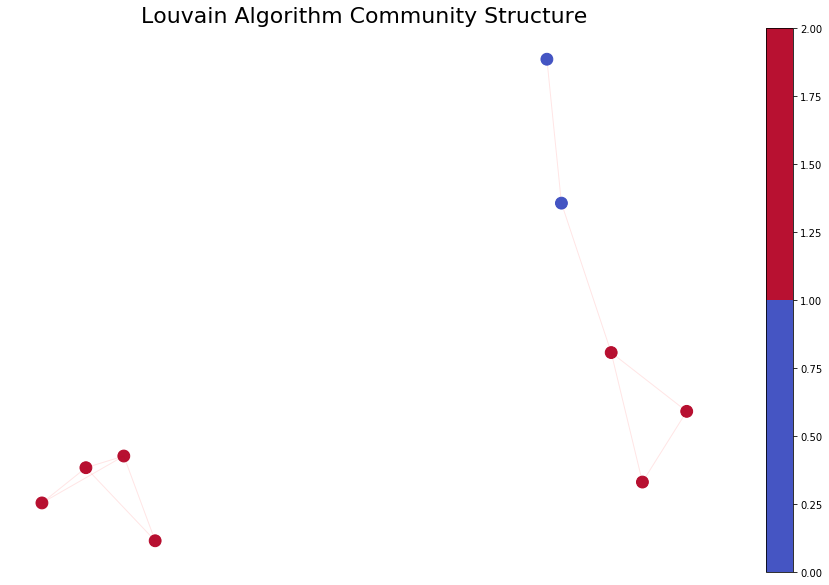

In [1078]:
import community
import matplotlib.pyplot as plt
partition = community.best_partition(com_graph)

values = [partition.get(node) for node in com_graph.nodes()]
values=[partition.get(node) for node in com_graph.nodes()]
plt.rcParams['figure.figsize']= [16, 10]
measure_name = "Louvain Algorithm Community Structure"
pos = nx.spring_layout(com_graph, k=0.2, iterations=20)
nodes_plot=nx.draw_networkx_nodes(com_graph, pos, node_size=140, label=True, cmap=plt.get_cmap('coolwarm', len(com_graph.nodes())/4),node_color=values, alpha=0.95)
edges_plot=nx.draw_networkx_edges(com_graph, pos, edge_color='r', alpha=0.1)
plt.title(measure_name, fontsize=22, fontname='Arial')
plt.colorbar(nodes_plot)
plt.axis('off')
plt.show()

In [1079]:
community.modularity(partition, com_graph)

0.505

In [1080]:
partition

{3: 0, 4: 0, 7: 1, 9: 1, 10: 1, 0: 2, 1: 2, 2: 2, 8: 1}

In [1081]:
partition = sorted(partition.items(), key=lambda kv: kv[1], reverse=False)

In [1082]:
current = 0
print ("--------------cluster " + str(0) + "------------ \n ")
for word, cluster in partition:
    if cluster!=current:
        print ("--------------cluster " + str(cluster) + "------------ \n ")
        print ("-> ",mod_texts[word])
        current=cluster
    else:
        print ("-> ",mod_texts[word])

--------------cluster 0------------ 
 
->  I am going to answer top free asking about Python. What is Python what it it and why it so popular in what does do that programming and language. I thought the fast growing and most popular language not just own offering to engineering, but all to have account that is engineer that kit because it is still same in a friendly pertinent language. So people who do a additional just point for right of different tasks, which just need alysis and have our artificial intelligence task at when learning automation in fact, this is one of the big of Python amongst people are not suffer markers. If he some exploring or the time is copied five of folders around name of them not uploading them to the server. It is easily write a license to automate all that time and that is just for to example, could have spreadsheet fifty down website to automate all the stuff python. So you have to be stuck with twelve Python which was an count us and or asigned and just 

In [1083]:
clusters = []
temp = []
prev_com = 0
for index,(word,cluster) in enumerate(partition):
    if prev_com==cluster:
        temp.append(word)
        #print (temp)
        if index==len(partition)-1:
            clusters.append(temp)
    else:
        clusters.append(temp)
        temp = []
        prev_com = cluster
        temp.append(word)

In [1084]:
timerange = []
temp = []
for index, cluster in enumerate(clusters):
    temp= []
    for sent in cluster:
        temp2 = [(sentence,start_time,user) for sentence,start_time,user in segment_contents.values() if mod_texts[sent] in sentence]
        if len(temp2)!=0:
            temp.append(temp2[0])
    if len(temp)!=0:
        temp = sorted(temp,key=lambda kv: kv[1])
        timerange.append(temp)
    else:
        print (cluster)

In [1085]:
timerange

[[('I am going to answer top free asking about Python. What is Python what it it and why it so popular in what does do that programming and language. I thought the fast growing and most popular language not just own offering to engineering, but all to have account that is engineer that kit because it is still same in a friendly pertinent language. So people who do a additional just point for right of different tasks, which just need alysis and have our artificial intelligence task at when learning automation in fact, this is one of the big of Python amongst people are not suffer markers. If he some exploring or the time is copied five of folders around name of them not uploading them to the server. It is easily write a license to automate all that time and that is just for to example, could have spreadsheet fifty down website to automate all the stuff python. So you have to be stuck with twelve Python which was an count us and or asigned and just python on the domain live easier. It ca

In [1086]:
timerange_detailed = []
temp = []
flag = False
pims = {}
index_pim = 0
index_segment = 0
for index,com in enumerate(timerange):
    temp = []
    flag = False
    #print ("-----community-----", index)
    for (index1,(sent1,time1,user1)), (index2,(sent2,time2,user2)) in zip(enumerate(com[0:]),enumerate(com[1:])):
        if sent1!=sent2:
            #print (time1, time2, (time2-time1).seconds)
            if ((time2-time1).seconds<=120):
                if not flag:
                    pims[index_pim] = {'segment'+str(index_segment):[sent1,time1,user1]}
                    index_segment+=1
                    temp.append((sent1,time1,user1))
                #else:
                    #print ('removing',time1, time2)
                    #temp.pop()
                pims[index_pim]['segment'+str(index_segment)] = [sent2,time2,user2]
                index_segment+=1
                temp.append((sent2,time2,user2))
                flag=True
            else:
                #print (time2, time1)
                if flag==True:
                    index_pim+=1
                    index_segment=0
                flag=False
    if flag==True:
        index_pim+=1
        index_segment=0
    #print ("-----timeRange-----\n", [j for i,j,k in temp])
    timerange_detailed.append(temp)            

In [1087]:
from graphrank.graphrank import GraphRank
from graphrank.utils import GraphUtils, TextPreprocess

keyphrase_text = ""
keyphrases_list = []
keyphrases = []
for index_pim in pims.keys():
    keyphrase_text = ""
    for seg in pims[index_pim]:
        if seg != "keyphrase":
            keyphrase_text += (' ' + pims[index_pim][seg][0])
    gr = GraphRank()
    tp = TextPreprocess()
    utils = GraphUtils()

    original_tokens, pos_tuple, filtered_pos_tuple = tp.preprocess_text(keyphrase_text, filter_by_pos=True, pos_filter=['NOUN', 'PROPN', 'ADJ', 'FW'], stop_words=False)

    word_graph = gr.build_word_graph(filtered_pos_tuple, original_tokens=original_tokens, window=4, reset_graph_context=True, preserve_common_words=False)

    keyphrases = gr.get_keyphrases(word_graph, normalize_nodes='degree')
    pims[index_pim]['keyphrase'] = [phrases for phrases, score in keyphrases]

In [1088]:

yet_to_combine = []
need_to_remove = []
for index1,i in enumerate(pims.keys()):
    for index2,j in enumerate(pims.keys()):
        if index1!=index2:
            if pims[i]['segment0'][1] >= pims[j]['segment0'][1] and pims[i]['segment0'][1] <= pims[j]['segment'+str(len(pims[j].values())-2)][1]:
                if (j,i) not in yet_to_combine and i not in need_to_remove and j not in need_to_remove:
                    yet_to_combine.append((i,j))
                    need_to_remove.append(i)

In [1089]:
for i,j in yet_to_combine:
    for k in pims[i]:
        if k!="keyphrase":
            if pims[i][k] not in pims[j].values():
                pims[j]['segment'+str(len(pims[j].values())-1)] = pims[i][k]
                #print (pims[i][k])
                continue
        else:
            extra_keyphrase = list(set(pims[i]['keyphrase'] + pims[j]['keyphrase']))
            pims[j]['keyphrase']=extra_keyphrase

In [1090]:
for i in need_to_remove:
    pims.pop(i)

In [1091]:
# meeting start time.
m_time = formatTime("2019-07-24T15:55:00Z", True)
for i in pims.keys():
    print ("\n\n\nPIMs ", i)
    print ("\n\nDiscussion:\n\n ")
    for seg in pims[i]:
        if seg!="keyphrase":
            print ("Minutes from the start of the meeting: ", pims[i][seg][1] - m_time , "\n")
            print (pims[i][seg][1], " ", pims[i][seg][0],"\n")
    print ("Keyphrases:\n\n ", pims[i]['keyphrase'])




PIMs  0


Discussion:

 
Minutes from the start of the meeting:  -21 days, 18:13:47 

2019-07-04 10:08:47   I am going to answer top free asking about Python. What is Python what it it and why it so popular in what does do that programming and language. I thought the fast growing and most popular language not just own offering to engineering, but all to have account that is engineer that kit because it is still same in a friendly pertinent language. So people who do a additional just point for right of different tasks, which just need alysis and have our artificial intelligence task at when learning automation in fact, this is one of the big of Python amongst people are not suffer markers. If he some exploring or the time is copied five of folders around name of them not uploading them to the server. It is easily write a license to automate all that time and that is just for to example, could have spreadsheet fifty down website to automate all the stuff python. So you have to be stu